In [1]:
!pip -q install torchinfo
!pip -q install torchview

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from torchinfo import summary
from torchview import draw_graph

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import os
import glob

from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

# Helper Function

In [4]:
def test_model(model, x):
  preds = model(x)
  print(preds.shape)

  print("Input :", x.shape)
  print("Output :", preds.shape)

  # Modified assertion to check batch size and spatial dimensions, allowing channel dimension to differ
  assert preds.shape[0] == x.shape[0] and preds.shape[2:] == x.shape[2:]

In [5]:
def find_all_image_paths(directory_path):
    """
    Finds all image files in the given directory and its subdirectories.

    Supported formats:
    .png, .jpg, .jpeg, .bmp, .tiff, .tif, .webp, .gif

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all image files found.
    """

    image_extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp',
                        '*.tiff', '*.tif', '*.webp', '*.gif')

    image_paths = []

    for ext in image_extensions:
        search_pattern = os.path.join(directory_path, '**', ext)
        image_paths.extend(glob.glob(search_pattern, recursive=True))
        search_pattern_upper = os.path.join(directory_path, '**', ext.upper())
        image_paths.extend(glob.glob(search_pattern_upper, recursive=True))

    return image_paths

In [6]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("💾 Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("🚀 Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [7]:
def val_loss(loader, model, loss_fn, device="cuda"):
    model.eval()
    losses = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

In [8]:
# # Source - https://stackoverflow.com/a/71999355
# # Posted by KarelZe, modified by community. See post 'Timeline' for change history
# # Retrieved 2026-01-27, License - CC BY-SA 4.0

# class EarlyStopping:
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:
#                 self.early_stop = True

import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# UNet with attention

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # 1st Conv layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias is false becouse we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # 2nd Conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: decoder feature (gating signal)
        x: encoder feature (skip connection)
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder + Attention
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2
                )
            )

            self.attentions.append(
                AttentionGate(
                    F_g=feature,
                    F_l=feature,
                    F_int=feature // 2
                )
            )

            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder with attention
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)

            skip = skip_connections[idx // 2]

            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)

            # Attention applied here
            skip = self.attentions[idx // 2](g=x, x=skip)

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [10]:
model = AttentionUNet(in_channels=3, out_channels=1)

summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUNet                            [1, 1, 256, 256]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [1, 64, 256, 256]         38,848
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [1, 128, 128, 128]        221,696
├─MaxPool2d: 1-4                         [1, 128, 64, 64]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [1, 256, 64, 64]          885,760
├─MaxPool2d: 1-6                         [1,

In [11]:
# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True)
# model_graph.visual_graph

# Hyper parameters

In [12]:
LEARNING_RATE = 2e-4
NUM_EPOCHS = 100
NUM_WORKERS = 2

# Batch size
TRANING_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

# Image Config
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
CHANNELS_IMG = 3

# Early stoping
PATIENCE = 5
MINI_DELTA = 1e-3

# Load and save model
LOAD_MODEL = False
SAVE_MODEL = True

CHECK_VALIDATION_LOSS = True

CHECKPOINT = "my_checkpoint.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

TRAIN_DATA_SHUFFLE = True
VAL_DATA_SHUFFLE = False
TEST_DATA_SHUFFLE = True

DATASET_ROOT_DIR = "/kaggle/input/breast-cancer-cell-segmentation"

IMAGES_DIR = os.path.join(DATASET_ROOT_DIR, "Images")
MASKS_DIR = os.path.join(DATASET_ROOT_DIR, "Masks")

# Dataset Process pipeline

In [13]:
images = find_all_image_paths(IMAGES_DIR)
masks = find_all_image_paths(MASKS_DIR)

images.sort()
masks.sort()

dataset = []
for image, mask in zip(images, masks):
  dataset.append((image, mask))

train_paths, val_paths = train_test_split(dataset, test_size=0.2, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")

Train size: 46
Val size: 12


In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_path, mask_path = self.dataset[idx]
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path), dtype=np.float32)
    mask[mask == 255.0] = 1.0 # Uncommented this line to normalize masks

    if self.transform is not None:
      argumentation = self.transform(image=image, mask=mask)
      image = argumentation["image"]
      mask = argumentation["mask"]

    return image, mask

Image shape: (768, 896, 3)
Mask shape: (768, 896)

Image dtype: uint8
Mask dtype: float32

Image min: 30 | Image max: 255
Mask min: 0.0 | Mask max: 1.0



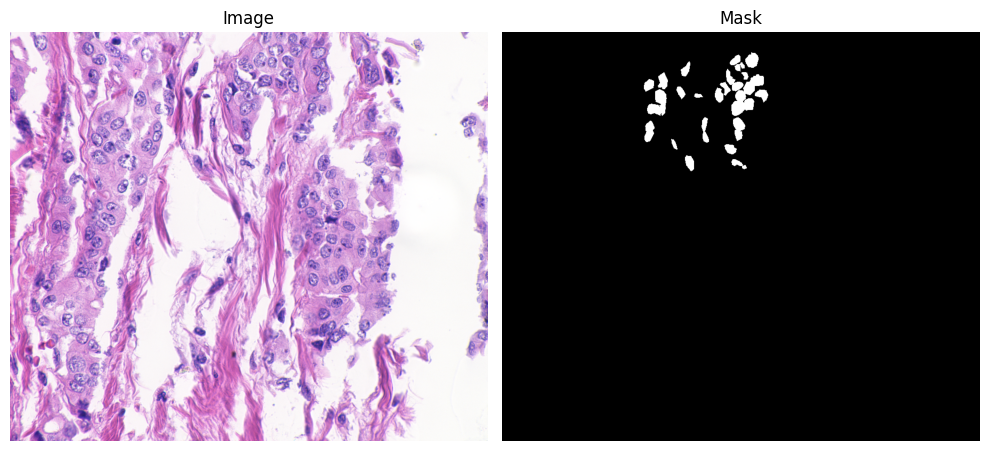

In [15]:
test_data = SegmentationDataset(dataset)

img = test_data[23]

print(f"Image shape: {img[0].shape}")
print(f"Mask shape: {img[1].shape}\n")

print(f"Image dtype: {img[0].dtype}")
print(f"Mask dtype: {img[1].dtype}\n")

print(f"Image min: {img[0].min()}", "|", f"Image max: {img[0].max()}")
print(f"Mask min: {img[1].min()}", "|", f"Mask max: {img[1].max()}\n")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0])
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(img[1], cmap="gray")
ax[1].set_title("Mask")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

# Loss Function and Accuracy Matrix

In [16]:
# ---------------------------
# Dice Loss 
# ---------------------------
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    y_true: (N, 1, H, W) or (N, H, W)
    y_pred: (N, 1, H, W) or (N, H, W) - probabilities (after sigmoid)
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    intersection = (y_true * y_pred).sum()
    dice = (2. * intersection + smooth) / (
        y_true.sum() + y_pred.sum() + smooth
    )

    return 1 - dice


# ---------------------------
# BCE + Dice Loss 
# ---------------------------
def bce_dice_loss(y_true, y_pred):
    """
    Combines Binary Cross Entropy and Dice Loss
    """
    bce = F.binary_cross_entropy(y_pred, y_true)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc


# ---------------------------
# IoU Metric 
# ---------------------------
def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes IoU score
    """
    y_pred = (y_pred > 0.5).float()

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou


# ---------------------------
# Standalone soft_iou_loss helper function
# ---------------------------
def soft_iou_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    intersection = (y_true_flat * y_pred_flat).sum()
    union = y_true_flat.sum() + y_pred_flat.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou


class my_loss(nn.Module):
  def __init__(self):
    super(my_loss, self).__init__()
    # Instantiate BCEWithLogitsLoss in the constructor
    self.bce_loss = nn.BCEWithLogitsLoss()

  def forward(self, y_pred, y_true):
    # Calculate BCE loss
    bce = self.bce_loss(y_pred, y_true)

    # Apply sigmoid to predictions before calculating soft IoU loss
    predictions_sigmoid = torch.sigmoid(y_pred)
    iou_l = soft_iou_loss(y_true, predictions_sigmoid)
    dice = dice_loss(y_true, predictions_sigmoid)

    # Return the sum of BCE and soft IoU loss
    # return bce + iou_l
    # return bce + dice
    return bce + iou_l + dice

# Tranning Pipeline

In [17]:
def traning_fn(loader, model, optimizer, loss_fn, scaler):
  model.train()
  loop = tqdm(loader)
  running_loss = 0.0

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # Forward pass
    with torch.amp.autocast(device_type=DEVICE):
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    running_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  return running_loss / len(loader)

In [18]:
def main():
  train_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  # model = UNet(in_channels=3, out_channels=1).to(DEVICE)
  model = AttentionUNet(in_channels=3, out_channels=1).to(DEVICE)

  # loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = my_loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Load Dataset
  train_dataset = SegmentationDataset(train_paths, transform=train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size=TRANING_BATCH_SIZE, shuffle=TRAIN_DATA_SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  val_dataset = SegmentationDataset(val_paths, transform=val_transform)
  val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  print(f"Train batch size: {len(train_dataloader)}")
  print(f"Val batch size: {len(val_dataloader)}")
  # print(f"Test batch size: {len(test_dataloader)}\n")

  # Load model
  if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

  # Requred Variable
  scaler = torch.amp.GradScaler(device=DEVICE)

  # early_stopping = EarlyStopping(tolerance=4, min_delta=10)
  early_stopping = EarlyStopping(patience=PATIENCE, delta=MINI_DELTA)

  train_loss_list = []
  validation_loss_list = []

  # Traning Loop
  for epoch in range(NUM_EPOCHS):
    # Train Model
    train_loss = traning_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    print()
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
    print(f"Train loss: {train_loss}")

    # Save Model
    if SAVE_MODEL and epoch % 2 == 0:
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, CHECKPOINT)

    # early stopping
    # early_stopping(train_loss, validation_loss)
    # if early_stopping.early_stop:
    #   print("We are at epoch:", epoch)
    #   break

    # Update traing and validation loss
    train_loss_list.append(train_loss)

    # Check Validation
    if CHECK_VALIDATION_LOSS:
      validation_loss = val_loss(val_dataloader, model, loss_fn, device=DEVICE)
      print(f"Validation loss: {validation_loss}")
      early_stopping(validation_loss, model)
      validation_loss_list.append(validation_loss)

      if early_stopping.early_stop:
          print("Early stopping")
          break
      else:
        print(f"patience: {early_stopping.counter} out of {early_stopping.patience}")
          
  early_stopping.load_best_model(model)
    
  return model, train_loss_list, validation_loss_list

In [19]:
model, train_losses, val_losses = main()

Train batch size: 6
Val batch size: 3


100%|██████████| 6/6 [00:06<00:00,  1.15s/it, loss=2.48]



Epoch: 1/100
Train loss: 2.5300748348236084
💾 Saving checkpoint
Validation loss: 2.589874585469564
patience: 0 out of 5


100%|██████████| 6/6 [00:04<00:00,  1.21it/s, loss=2.32]


Epoch: 2/100
Train loss: 2.389608462651571


Validation loss: 2.5643064975738525
patience: 0 out of 5


100%|██████████| 6/6 [00:04<00:00,  1.20it/s, loss=2.3]



Epoch: 3/100
Train loss: 2.3124428590138755
💾 Saving checkpoint
Validation loss: 2.4908284346262612
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.20it/s, loss=2.24]


Epoch: 4/100
Train loss: 2.271770715713501


Validation loss: 2.379398981730143
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.17it/s, loss=2.24]



Epoch: 5/100
Train loss: 2.251733144124349
💾 Saving checkpoint
Validation loss: 2.306113084157308
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.20it/s, loss=2.23]


Epoch: 6/100
Train loss: 2.239589810371399


Validation loss: 2.2683099110921225
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.19it/s, loss=2.2]



Epoch: 7/100
Train loss: 2.2244957288106284
💾 Saving checkpoint
Validation loss: 2.250069777170817
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.19it/s, loss=2.2]


Epoch: 8/100
Train loss: 2.2158955335617065


Validation loss: 2.2415459950764975
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.18it/s, loss=2.2]



Epoch: 9/100
Train loss: 2.2076410055160522
💾 Saving checkpoint
Validation loss: 2.2291882038116455
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.18it/s, loss=2.19]


Epoch: 10/100
Train loss: 2.200192133585612


Validation loss: 2.2192190488179526
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.17it/s, loss=2.18]



Epoch: 11/100
Train loss: 2.1922188997268677
💾 Saving checkpoint
Validation loss: 2.209400733311971
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.16it/s, loss=2.2]


Epoch: 12/100
Train loss: 2.189285238583883


Validation loss: 2.2010134855906167
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.16it/s, loss=2.17]



Epoch: 13/100
Train loss: 2.1831831137339273
💾 Saving checkpoint
Validation loss: 2.1929733753204346
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.16it/s, loss=2.18]


Epoch: 14/100
Train loss: 2.17722753683726


Validation loss: 2.185141086578369
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.17it/s, loss=2.16]



Epoch: 15/100
Train loss: 2.1718536218007407
💾 Saving checkpoint
Validation loss: 2.182690699895223
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.16it/s, loss=2.18]


Epoch: 16/100
Train loss: 2.166182557741801


Validation loss: 2.1787487665812173
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.16it/s, loss=2.17]



Epoch: 17/100
Train loss: 2.1614453395207724
💾 Saving checkpoint
Validation loss: 2.163784662882487
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.14it/s, loss=2.15]


Epoch: 18/100
Train loss: 2.157786011695862


Validation loss: 2.1690800189971924
patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.15it/s, loss=2.13]



Epoch: 19/100
Train loss: 2.150826096534729
💾 Saving checkpoint
Validation loss: 2.168709913889567
patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.15it/s, loss=2.13]


Epoch: 20/100
Train loss: 2.1450723807017007


Validation loss: 2.149229129155477
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.14it/s, loss=2.11]



Epoch: 21/100
Train loss: 2.138412435849508
💾 Saving checkpoint
Validation loss: 2.1634063720703125
patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.15it/s, loss=2.13]


Epoch: 22/100
Train loss: 2.1337347428003945


Validation loss: 2.149916410446167
patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.15it/s, loss=2.13]



Epoch: 23/100
Train loss: 2.1285269260406494
💾 Saving checkpoint
Validation loss: 2.1315267086029053
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.14it/s, loss=2.1]


Epoch: 24/100
Train loss: 2.121275226275126


Validation loss: 2.139079729715983
patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.13it/s, loss=2.12]



Epoch: 25/100
Train loss: 2.1149851083755493
💾 Saving checkpoint
Validation loss: 2.113954782485962
patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.13it/s, loss=2.1]


Epoch: 26/100
Train loss: 2.1133679946263633


Validation loss: 2.1164797941843667
patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.12it/s, loss=2.15]



Epoch: 27/100
Train loss: 2.107585628827413
💾 Saving checkpoint
Validation loss: 2.1531155904134116
patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.12it/s, loss=2.09]


Epoch: 28/100
Train loss: 2.100858211517334


Validation loss: 2.144801616668701
patience: 3 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.12it/s, loss=2.1]



Epoch: 29/100
Train loss: 2.0948047240575156
💾 Saving checkpoint
Validation loss: 2.179605484008789
patience: 4 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.11it/s, loss=2.1]


Epoch: 30/100
Train loss: 2.089310606320699


Validation loss: 2.169990380605062
Early stopping


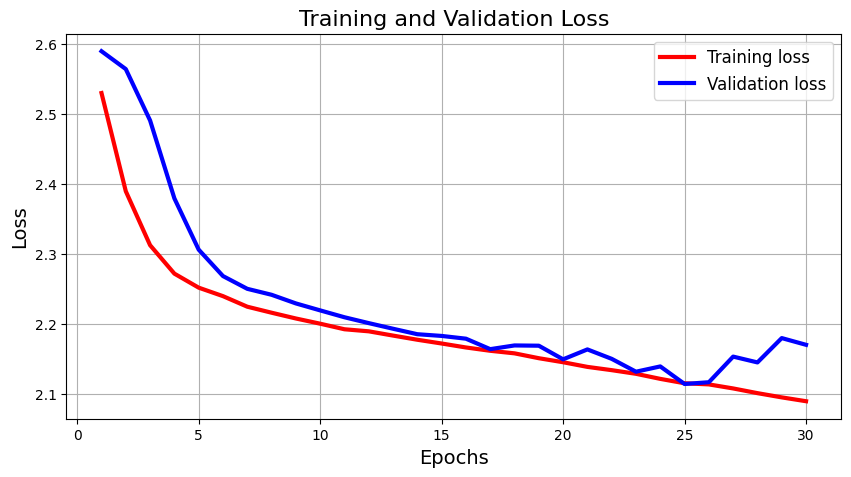

In [20]:
epochs = range(1, len(train_losses) + 1)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training loss', color='r', linewidth=3.0)
plt.plot(epochs, val_losses, label='Validation loss', color='b', linewidth=3.0)

# Adding titles and labels
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

# Model Evaluation

Test batch size: 12


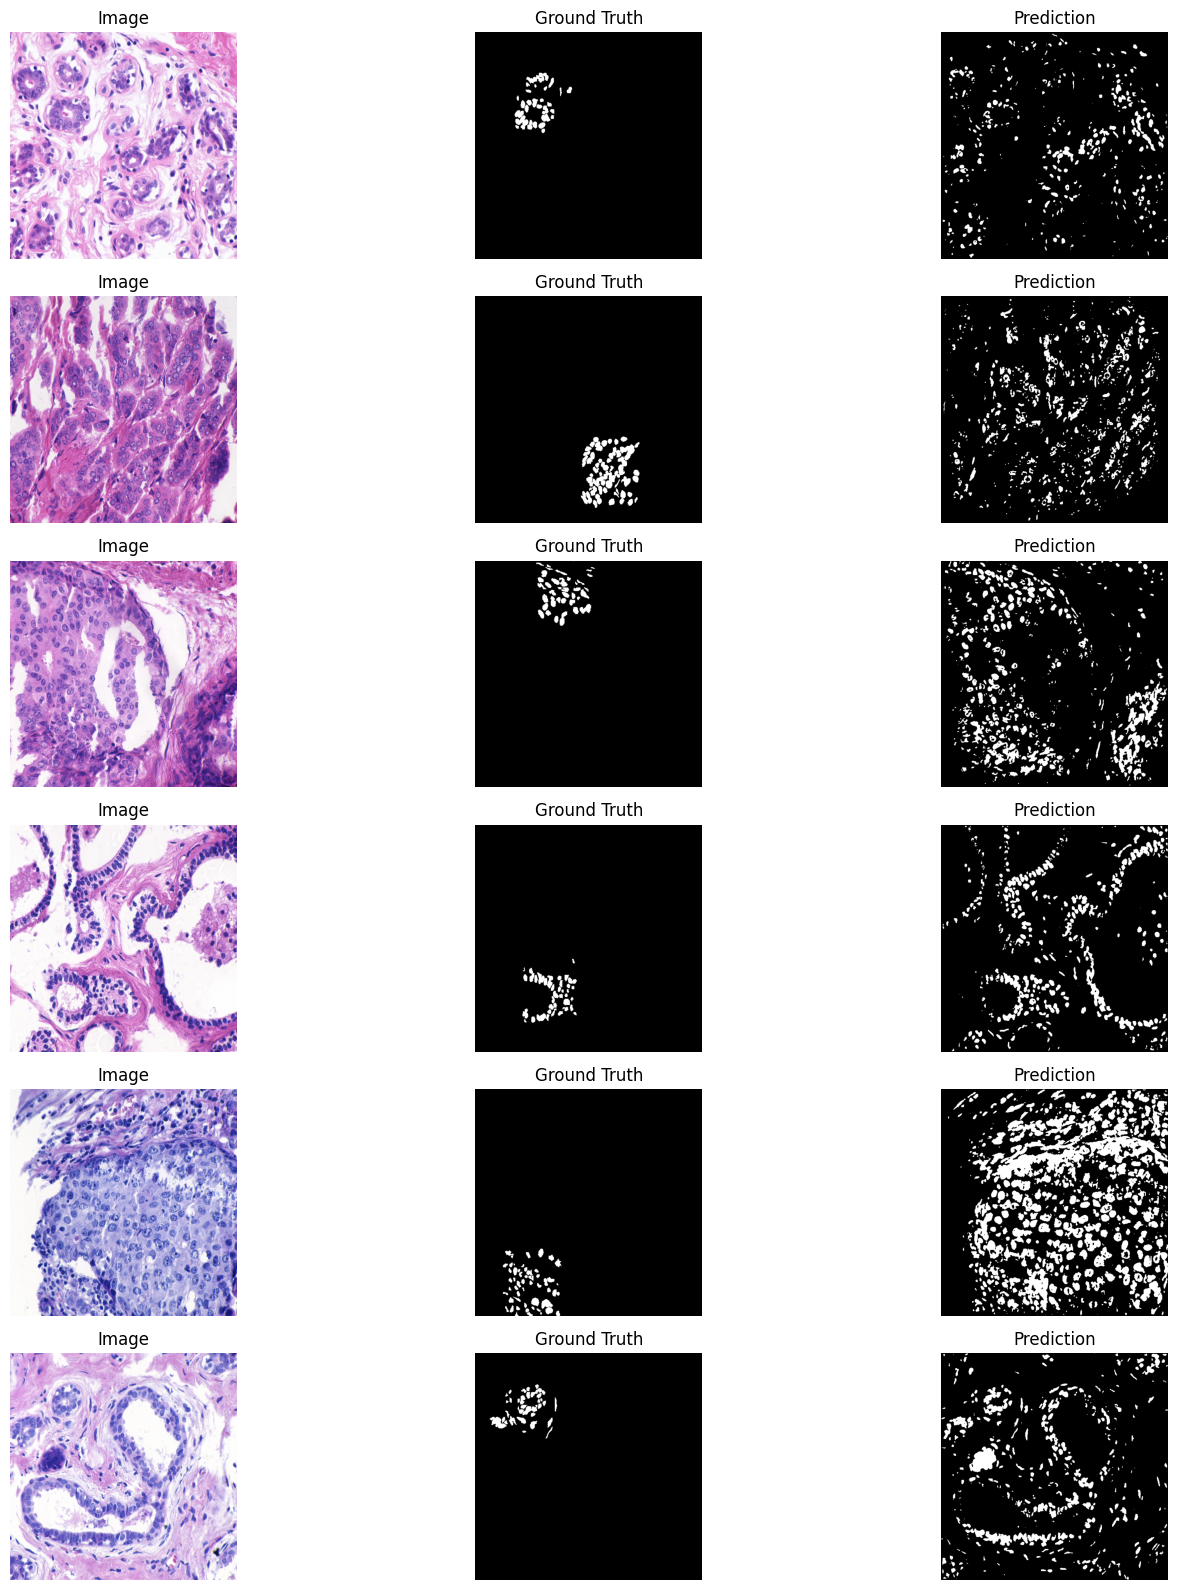

In [21]:
# load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

val_transform = A.Compose(
    [
      A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
    ],
)

val_dataset = SegmentationDataset(val_paths, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Test batch size: {len(val_dataloader)}")

model.eval()
fig, ax = plt.subplots(6, 3, figsize=(16, 16))

with torch.no_grad():
  for batch_idx, (data, targets) in enumerate(val_dataloader):
    if batch_idx >= 6: # Process only the first 5 batches
      break

    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    predictions = model(data)
    predictions = torch.sigmoid(predictions)
    predictions = (predictions >= 0.3).float()

    ax[batch_idx, 0].imshow(data[0].permute(1, 2, 0).cpu().numpy())
    ax[batch_idx, 0].set_title("Image")
    ax[batch_idx, 0].set_axis_off()

    ax[batch_idx, 1].imshow(targets[0].cpu().numpy().squeeze(), cmap="gray")
    ax[batch_idx, 1].set_title("Ground Truth")
    ax[batch_idx, 1].set_axis_off()

    ax[batch_idx, 2].imshow(predictions[0].cpu().numpy().squeeze(), cmap="gray")
    ax[batch_idx, 2].set_title("Prediction")
    ax[batch_idx, 2].set_axis_off()

  plt.tight_layout()
  plt.show()

In [22]:
def calculate_tp_tn_fp_fn(y_true, y_pred):
    """
    Calculates True Positives, True Negatives, False Positives, and False Negatives.
    y_true: (N, H, W) or (N, 1, H, W) binary masks (ground truth)
    y_pred: (N, H, W) or (N, 1, H, W) binary masks (predictions)
    """
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    # Ensure tensors are boolean or 0/1 for logical operations
    y_true_bool = y_true_flat.bool()
    y_pred_bool = y_pred_flat.bool()

    TP = torch.sum(y_true_bool & y_pred_bool).float()
    TN = torch.sum(~y_true_bool & ~y_pred_bool).float()
    FP = torch.sum(~y_true_bool & y_pred_bool).float()
    FN = torch.sum(y_true_bool & ~y_pred_bool).float()

    return TP, TN, FP, FN

def accuracy_metric(TP, TN, FP, FN):
    """
    Calculates accuracy.
    """
    total_pixels = TP + TN + FP + FN
    if total_pixels == 0:
        return torch.tensor(0.0)
    return (TP + TN) / total_pixels

def precision_metric(TP, FP, smooth=1e-8):
    """
    Calculates precision. Handles division by zero.
    """
    denominator = TP + FP
    if denominator == 0:
        return torch.tensor(0.0)
    return TP / denominator

def recall_metric(TP, FN, smooth=1e-8):
    """
    Calculates recall. Handles division by zero.
    """
    denominator = TP + FN
    if denominator == 0:
        return torch.tensor(0.0)
    return TP / denominator

def f1_score_metric(precision, recall, smooth=1e-8):
    """
    Calculates F1 score. Handles division by zero.
    """
    denominator = precision + recall
    if denominator == 0:
        return torch.tensor(0.0)
    return 2 * (precision * recall) / denominator

In [23]:
def model_evaluation(model, test_dataloader, device):
  model.eval()
  # Accumulators for metrics
  total_tp, total_tn, total_fp, total_fn = 0.0, 0.0, 0.0, 0.0
  total_dice_score = 0.0
  total_iou_score = 0.0

  print("Starting model evaluation...")
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
      data = data.to(device=device)
      targets = targets.float().unsqueeze(1).to(device=device)

      # Make predictions and convert to binary masks
      predictions = torch.sigmoid(model(data))
      predictions = (predictions > 0.3).float()

      # Ensure targets are also binary
      targets_binary = (targets > 0.3).float()

      # Calculate TP, TN, FP, FN for current batch
      TP, TN, FP, FN = calculate_tp_tn_fp_fn(targets_binary, predictions)
      total_tp += TP
      total_tn += TN
      total_fp += FP
      total_fn += FN

      # Calculate Dice score for current batch
      dice = (2 * (predictions * targets_binary).sum(dim=(2,3)) + 1e-8) / (
          predictions.sum(dim=(2,3)) + targets_binary.sum(dim=(2,3)) + 1e-8
      )
      total_dice_score += dice.mean().item()

      # Calculate IoU for current batch
      iou = iou_metric(targets_binary, predictions)
      total_iou_score += iou.mean().item()

  # Aggregate metrics over all batches
  num_samples = len(test_dataloader)

  # Accuracy
  overall_accuracy = accuracy_metric(total_tp, total_tn, total_fp, total_fn)

  # Precision
  overall_precision = precision_metric(total_tp, total_fp)

  # Recall
  overall_recall = recall_metric(total_tp, total_fn)

  # F1 Score
  overall_f1_score = f1_score_metric(overall_precision, overall_recall)

  # Dice Coefficient (mean over all batches)
  overall_dice_coefficient = total_dice_score / num_samples

  # IoU (mean over all batches)
  overall_iou = total_iou_score / num_samples

  print("\n--- Model Evaluation Results ---")
  print(f"Overall Accuracy: {overall_accuracy:.4f}")
  print(f"Overall Precision: {overall_precision:.4f}")
  print(f"Overall Recall: {overall_recall:.4f}")
  print(f"Overall F1 Score: {overall_f1_score:.4f}")
  print(f"Overall Dice Coefficient: {overall_dice_coefficient:.4f}")
  print(f"Overall IoU: {overall_iou:.4f}")
  print("--------------------------------")

  model.train()
  return {
      "accuracy": overall_accuracy.item(),
      "precision": overall_precision.item(),
      "recall": overall_recall.item(),
      "f1_score": overall_f1_score.item(),
      "dice_coefficient": overall_dice_coefficient,
      "iou": overall_iou
  }



In [24]:
metrics = model_evaluation(model, val_dataloader, DEVICE)

Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s]


--- Model Evaluation Results ---
Overall Accuracy: 0.8918
Overall Precision: 0.1019
Overall Recall: 0.6650
Overall F1 Score: 0.1767
Overall Dice Coefficient: 0.2019
Overall IoU: 0.1169
--------------------------------
